# Installation of external packages

In [1]:
!pip install numpy==1.23.5    # version compatible with qiskit
!pip install qutip==5.0.3
!pip install tqdm==4.66.5

# Standard imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import axes
from tqdm.notebook import trange

# Constants and unit conversion factors

In [3]:
au2ev = 27.21138602
ev2au = 1/au2ev
bohr2au = 0.52917721092
au2bohr = 1/bohr2au
fs2au = 41.3414
au2fs = 1/fs2au

mass_proton = 1836.15 # proton mass in units of electron mass

# Section 3. Workflow for Quantum Dynamics Simulations

## Section 3.1. Quantum Dynamics of a Harmonic Oscillator

### QuTiP propagation of the coherent state in harmonic potential

Before we look at doing Quantum Dynamics on a quantum computer, we'll start out by looking at some ways that we can do quantum dynamics on a classical computer! This is an important step as it will familiarize you with the general ingredients of a quantum dynamics simulation and will also provide us with a means of validating the results obtained from a quantum computer.

We begin by showing a simple example of how to compute dynamics of an initial state using QuTiP's mesolve() function. When we run dynamics, we must do the following:

1. **Define the initial state** $\left| \alpha \right\rangle$. In this example, our initial state is defined as a coherent state with amplitude $\alpha = x_{0} + i p_{0}$, which can be expressed in the Fock Basis as:
     
    $$ \left| \alpha \right\rangle = \sum_{n=0}^\infty\frac{\alpha^{n}}{\sqrt{n!}} e^{-\frac{1}{2}\left| \alpha \right|^{2}} \left| n \right\rangle $$
     
2. **Define the Hamiltonian** $H$. In this example, our Hamiltonian is the familiar quantum harmonic oscillator Hamiltonian, defined in terms of creation and annihilation operators as:

$$ H =  \hbar \omega \left( \hat{a}^{\dagger} \hat{a} + \frac{1}{2} \right) $$

3. **Define the propagation time step $t$ and the number of time steps $n$ for which to compute the wavefunction.**

4. **Compute the time-evolved wavefunction at each step as:**

$$ \left| \alpha (t_{i+1}) \right\rangle = e^{-\frac{i}{\hbar} H t} \left| \alpha(t_{i}) \right\rangle $$

<!-- **Note:** For a coherent state, the time evolution within the harmonic oscillator takes the form of:

$$  \begin{align*}
        \left| \psi (t) \right\rangle &= e^{-\frac{1}{2} \left| \alpha \right|^{2}} \sum_{n=0}^{\infty} \frac{\alpha_{0}^{n}}{\sqrt{n!}} e^{- i \omega \left( n + \frac{1}{2} \right) t} \left| n \right\rangle \\
                                      &= e^{- i \omega t /2} e^{-\frac{1}{2} \left| \alpha \right|^{2}} \sum_{n=0}^{\infty} \frac{\left( \alpha_{0} e^{- i \omega t} \right)^{n}}{\sqrt{n!}} \left| n \right\rangle \\
    \end{align*}
$$ -->


In [4]:
import qutip as qt

# Define the Number of States in Fock Basis
N = 128
a = qt.destroy(N)  # Define annihilation operator

# Define the Initial State:
x_0 = 1.00   # Initial Position
p_0 = 0.00   # Initial Momentum

# Define a coherent state with amplitude alpha
psi_0 = qt.coherent(N, alpha=(x_0 + 1.j*p_0)/np.sqrt(2))

# Define the Hamiltonian:
mass = 1     # mass = 1.0
hbar = 1     # hbar = 1.0
omega = 1.0  # Oscillator frequency

x = qt.position(N) # Should be equivalent to (a + a.dag())/np.sqrt(2.)
p = qt.momentum(N)

H_hoxp = p**2/(2*mass) + mass*omega**2*x**2/2   # Harmonic Oscillator Hamiltonian
H_ho = hbar*omega*(a.dag()*a + 1./2.)   # Harmonic Oscillator Hamiltonian

# Define the propagation time array with n_steps from 0 to total_time
n_steps = 400   # Number of time steps
total_time = 20 # Total Propagation time

# Define the list of times for which we calculate dynamics.
tlist = np.linspace(0, total_time, n_steps)

# Run dynamics!
solver_options = {'nsteps': len(tlist), 'progress_bar': True}
result = qt.sesolve(H_ho, psi_0, tlist, [], [], options=solver_options)

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.1%. Run time:   0.04s. Est. time left: 00:00:00:00
30.1%. Run time:   0.07s. Est. time left: 00:00:00:00
40.1%. Run time:   0.10s. Est. time left: 00:00:00:00
50.1%. Run time:   0.12s. Est. time left: 00:00:00:00
60.2%. Run time:   0.14s. Est. time left: 00:00:00:00
70.2%. Run time:   0.15s. Est. time left: 00:00:00:00
80.2%. Run time:   0.18s. Est. time left: 00:00:00:00
90.2%. Run time:   0.19s. Est. time left: 00:00:00:00
100.0%. Run time:   0.21s. Est. time left: 00:00:00:00
Total run time:   0.21s


### Plotting Expectation Values

<!-- One of the useful things we can do with the result of our quantum dynamics calculation is compute expectation values.

For example, we can consider some expectation values of our initial states:

Recall that: $\hat{a} | \alpha\ \rangle = \alpha | \alpha \rangle \ \ \ \textrm{ and } \ \ \ \langle \alpha | \hat{a}^{\dagger} = \alpha^{*} \langle \alpha |$


Then the expected position of our initial state can be computed as:


\begin{split}
\left \langle \hat{X} \right \rangle & = \left \langle \alpha \middle| \frac{1}{\sqrt{2}} \left( \hat{a} + \hat{a}^{\dagger} \right) \middle| \alpha \right \rangle \\
& = \frac{1}{\sqrt{2}} \left( \left \langle \alpha \middle| \hat{a} \middle| \alpha \right \rangle + \left \langle \alpha \middle| \hat{a}^{\dagger} \middle| \alpha \right \rangle \right) \\
& = \frac{1}{\sqrt{2}} \left( \alpha + \alpha^{*} \right) \\
& = \sqrt{2}  \ \mathbf{Re}\left[ \alpha \right]
\end{split}

We can do the same for the momentum:

\begin{split}
\left \langle \hat{P} \right \rangle & = \frac{- i \hbar}{\sqrt{2}} \left \langle \alpha \middle| \left( \hat{a} - \hat{a}^{\dagger} \right) \middle| \alpha \right \rangle \\
& = \frac{- i \hbar}{\sqrt{2}} \left( \left \langle \alpha \middle| \hat{a} \middle| \alpha \right \rangle - \left \langle \alpha \middle| \hat{a}^{\dagger} \middle| \alpha \right \rangle \right) \\
& = \frac{- i \hbar}{\sqrt{2}} \left( \alpha - \alpha^{*} \right) \\
& = \sqrt{2} \hbar \ \mathbf{Im} \left[ \alpha \right]
\end{split} -->

In [5]:
X_op = (a.dag() + a)/np.sqrt(2)
P_op = 1j*(a.dag() - a)/np.sqrt(2)

#exp_x_qtxp = qt.expect(X_op, resultxp.states)
#exp_p_qtxp = qt.expect(P_op, resultxp.states)
exp_x_qt = qt.expect(X_op, result.states)
exp_p_qt = qt.expect(P_op, result.states)

exp_x_ana = [ x_0*np.cos(omega*t) + (p_0/mass/omega)*np.sin(omega*t) for t in tlist]
exp_p_ana = [ p_0*np.cos(omega*t) -x_0*omega*mass*np.sin(omega*t)  for t in tlist]

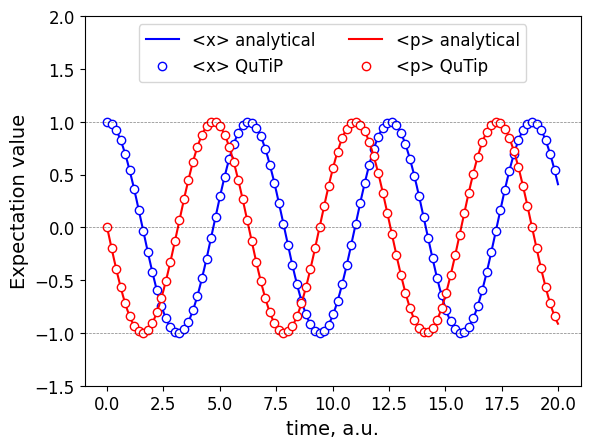

In [6]:
tlist = np.linspace(0, total_time, n_steps)
fig, ax = plt.subplots()
ax.plot(tlist, exp_x_ana, '-', color='blue', label='<x> analytical', zorder=0)
ax.plot(tlist[::4], exp_x_qt[::4], 'o', color='blue', label='<x> QuTiP', zorder=0, markeredgecolor='blue', fillstyle='full', markerfacecolor='white')
ax.plot(tlist, exp_p_ana, '-', color='red',label='<p> analytical', zorder=2)
ax.plot(tlist[::4], exp_p_qt[::4], 'o', color='red',label='<p> QuTip', zorder=2, markeredgecolor='red', fillstyle='full', markerfacecolor='white')
ax.axhline(-1, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axhline( 0, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axhline( 1, ls='--', lw=0.5, color='black', alpha=0.5)
ax.set_xlabel('time, a.u.', fontsize=14)
ax.set_ylabel('Expectation value', fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-1.5,2.)
plt.legend(fontsize=12,loc='upper center', ncol=2)
plt.show()

## Section 3.2. Split-Operator Fourier Transform (SOFT) Method

Here, we compute the time-evolution of a wavepacket defined in the position basis ($\psi(x)$) according to the Split-Operator Fourier Transform (SOFT) method. This differs slightly from the approach utilized in the last section in the following ways:

- As mentioned above, we will describe the wavefunction in terms of the position. To do this, we must define a closed range of positions $x$ and momenta $p$ and discretize over some finite number of points (analagous to the finite number of Fock states considered above).
- We will compute the time evolution as:
$$ \left| \psi (t) \right\rangle =  e^{- \frac{i}{\hbar} {H} t} \left| \psi(0) \right\rangle $$
Writing $H$ in terms of Kinetic and Potential energy $H = T + V$:
$$ \begin{align*}
        \left| \psi (t) \right\rangle &\approx \lim\limits_{N\to\infty} \left[e^{\frac{-ip^2t}{2m\hbar N}}\ e^{\frac{-i{V}({x})t}{\hbar N}}\right]^N \space |\psi(0)\rangle \\
                                  &\approx\lim\limits_{N\to\infty} \left[e^{\frac{-i{V}({x})t}{2\hbar N}}\space e^{\frac{-ip^2t}{2m\hbar N}}\space e^{\frac{-i{V}({x})t}{2\hbar N}}\right]^N \space |\psi(0)\rangle   
% Inserting closure and writing in the plane-wave basis:
%     \left| \psi (x, t) \right\rangle &= \int d x_0 \space \langle x_t | e^{\frac{-iĤt}{\hbar}} | x_0 \rangle \space \langle x_0 | \psi(0) \rangle
    \end{align*}
$$
    
Propagation for a single timestep is then:
$$\psi(x,\frac{t_{i+1}}{N}) =
\overbrace{\vphantom{\int \frac{dp}{\sqrt{2\hbar}} e^{\frac{-iV(x)p^{2}}{2 \hbar N}}} e^{\frac{-iV(x)t}{2\hbar N}} }^\textrm{P.E. Propagator} \ \cdot \
\overbrace{\vphantom{\int \frac{dp}{\sqrt{2\hbar}} e^{\frac{-iV(x)p^{2}}{2 \hbar N}}} \color{blue}   {\int \frac{dp}{\sqrt{2\pi\hbar}} \ e^{\frac{-ipx}{\hbar}}}}^\textrm{Inverse Fourier Transform} \ \cdot
\overbrace{\vphantom{\int \frac{dp}{\sqrt{2\hbar}} e^{\frac{-iV(x)p^{2}}{2 \hbar N}}} \ e^{\frac{-ip^2t}{2m\hbar N}}}^\textrm{K.E. Propagator} \ \cdot \
\overbrace{\vphantom{\int \frac{dp}{\sqrt{2\hbar}} e^{\frac{-iV(x)p^{2}}{2 \hbar N}}} \color{purple}{\int \frac{dx}{\sqrt{2\pi\hbar}} \ e^{\frac{ ipx}{\hbar}}}}^\textrm{Fourier Transform} \ \cdot \
\overbrace{\vphantom{\int \frac{dp}{\sqrt{2\hbar}} e^{\frac{-iV(x)p^{2}}{2 \hbar N}}}\ e^{\frac{-iV(x)t}{2\hbar N}} }^\textrm{P.E. Propagator} \ \cdot \ \psi(x,t_{i})
$$

The Fourier and inverse Fourier transforms are used to convert between the position and momentum basis. To translate the formula above, the algorithm will consist of 5 steps per iteration:

1. Apply a half step of the potential energy propagator to the initial state.
2. Fourier transform into the momentum basis.
3. Apply a full step of the kinetic energy propagator on the momentum basis.
4. Inverse Fourier transform back into the coordinate basis.
5. Apply the second half step of the potential energy propagator.

This is done with the following code:

```python
# SOFT propagation
def soft(psi,pot_prop,kin_prop):
    out=pot_prop*psi              # Apply P.E. propagator
    out=kin_prop*np.fft.fft(out)  # FT and apply K.E. propagator
    out=pot_prop*np.fft.ifft(out) # IFT and Apply P.E. propagator
    return out
```
Note that here we must define our coherent state in the coordinate representation:

$$ \psi_{0} = \left( \tfrac{m \omega}{\pi \hbar} \right)^{1/4} e^{- \tfrac{m \omega}{2 \hbar} \left( x - x_{0} \right)^{2} + \tfrac{i}{\hbar} p_{0} x } $$

### Grids in position and momentum spaces

### More functions

**Coherent state** for a harmonic oscillator in position representation:
$$
\langle{x}|\alpha\rangle = \psi^{(\alpha)}(x) =
\left(\dfrac{m\omega}{\pi\hbar}\right)^{1/4}
\exp\left[
 -\dfrac{m\omega}{2\hbar}
  \left(x - \sqrt{\dfrac{2\hbar}{m\omega}}\mathcal{Re}[\alpha]\right)^2
 +\dfrac{\text{i}}{\hbar}\sqrt{2m\omega\hbar}\mathcal{Im}[\alpha]x
  \right]
$$
where
$$
\langle x\rangle = \sqrt{\dfrac{2\hbar}{m\omega}}\,\mathcal{Re}[\alpha] \\
\langle p\rangle = \vphantom{\sqrt{\dfrac{2\hbar}{m\omega}}}\sqrt{2m\omega\hbar}\,\mathcal{Im}[\alpha]
$$

are the expectation values of the position and momentum, respectively.

**Probability density in position representation**:
$$
\rho(x) = \langle \psi|x\rangle\langle x|\psi\rangle = \psi^*(x)\,\psi(x)
$$

**Propagator (evolution operator)**:
$$
\hat{U}(\tau) = e^{-\frac{\text{i}}{\hbar}\hat{H}\tau}
$$

In [7]:
def get_xgrid(xmin, xmax, N_pts):
    dx = (xmax - xmin)/N_pts
    xgrid = np.arange(-N_pts/2, N_pts/2)*dx
    return xgrid

def get_pgrid(xmin, xmax, N_pts, reorder=True):
    dp = 2 * np.pi / (xmax-xmin)
    pmin = -dp * N_pts / 2
    pmax = dp * N_pts / 2
    plus_pgrid = np.linspace(0, pmax, N_pts//2+1)
    minus_pgrid = - np.flip(np.copy(plus_pgrid))
    if reorder:
        pgrid = np.concatenate((plus_pgrid[:-1], minus_pgrid[:-1]))
    else:
        pgrid = np.concatenate((minus_pgrid, plus_pgrid))
    return pgrid

def get_coherent_state(x, p_0, x_0, mass=1, omega=1, hbar=1):
    #Generate the initial wavefunction (psi0).
    normalization = (mass*omega/np.pi/hbar)**(0.25)
    y = normalization*np.exp(-1*(mass*omega/hbar/2)*((x-x_0)**2)+1j*p_0*x/hbar)
    return y

def get_prob_density(psi):
    return np.real(np.conjugate(psi) * psi)


def get_kinetic_energy(p, mass=1):
    return  p**2/2/mass


def get_propagator_on_grid(operator_grid, tau, hbar=1):
    '''
        operator_grid: a numpy array, expressing the operator on a grid
        tau: the time step for propagation (in atomic units of time), should be a small number
    '''
    return np.exp(-1.0j * operator_grid * tau / hbar)


def do_SOFT_propagation(psi, K_prop, V_prop):
    # np.fft.fft and np.fft.ifft requires specific ordering of outputs/inputs
    psi_t_position_grid = V_prop * psi
    psi_t_momentum_grid = K_prop * np.fft.fft(psi_t_position_grid, norm="ortho")
    psi_t = V_prop * np.fft.ifft(psi_t_momentum_grid, norm="ortho")
    return psi_t


def position_expectation_value(xgrid, psi):
    dx = xgrid[1]-xgrid[0]
    return dx*np.real(np.sum(xgrid * np.conjugate(psi) * psi))


def momentum_expectation_value(dx,pgrid, psi):
    psip = np.fft.fft(psi)
    return dx*np.real(np.sum(pgrid * np.conjugate(psip) * psip))/len(psi)



### SOFT propagation of a coherent state in harmonic potential

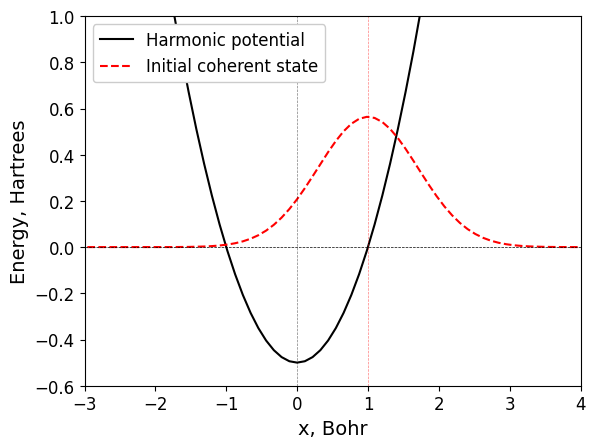

In [8]:
def get_harmonic_potential(x, x_0=0.0, mass=1, omega=1):
    return mass * omega**2 * (x - x_0)**2 / 2


xmin = -7.0
xmax = 7.0
N_pts = 128

# mass of the particle in units of electron mass
mass = 1.0

# frequency of the harmonic oscillator (in atomic units)
omega = 1.0

# grid preparation and spacing
xgrid = get_xgrid(xmin, xmax, N_pts)
dx = xgrid[1] - xgrid[0]
# Momentum Grid
pgrid = get_pgrid(xmin, xmax, N_pts, reorder=True)

# operators
Vx_harm = get_harmonic_potential(xgrid)
K_harm = get_kinetic_energy(pgrid, mass)

# initial coherent state - ground state Gaussian centered at x_0 = 1
x_0 = 1.0
p_0 = 0.0
psi_0 = get_coherent_state(xgrid, p_0, x_0, mass, omega)

# checking potential and initial coherent state
fig, ax = plt.subplots()
ax.plot(xgrid, Vx_harm - omega/2, '-',color='black',label='Harmonic potential')
ax.plot(xgrid, np.real(get_prob_density(psi_0)),'--',color='red',label='Initial coherent state')
ax.axhline(0, ls='--', lw=0.5, color='black', alpha=1.0)
ax.axvline(0, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axvline(1, ls='--', lw=0.5, color='red', alpha=0.5)
ax.set_xlabel('x, Bohr',fontsize=14)
ax.set_ylabel('Energy, Hartrees',fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-0.6,1.0)
plt.xlim(-3,4)
plt.legend(fontsize=12,loc='upper left',framealpha=1.0)
plt.show()

In [9]:
tmin = 0.0
tmax = 20.0
N_tsteps = 400

# grid preparation and spacing
tgrid = np.linspace(tmin, tmax, N_tsteps)
tau = tgrid[1] - tgrid[0]

print("For ", tmax, " a.u. using a timestep of ",tau," a.u.")

V_prop = get_propagator_on_grid(Vx_harm/2, tau)
K_prop = get_propagator_on_grid(K_harm, tau)

propagated_states_harm = [psi_0]
psi_t = psi_0
for tstep_idx in trange(len(tgrid)):
    psi_t = do_SOFT_propagation(psi_t, K_prop, V_prop)
    propagated_states_harm.append(psi_t)

propagated_states_harm = np.array(propagated_states_harm)[:-1]

For  20.0  a.u. using a timestep of  0.05012531328320802  a.u.


  0%|          | 0/400 [00:00<?, ?it/s]

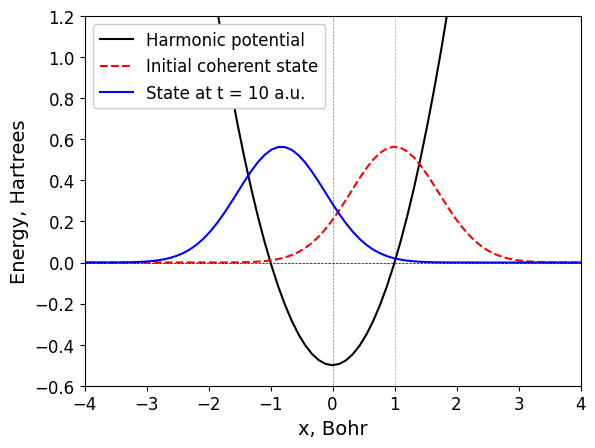

In [10]:
fig, ax = plt.subplots()
ax.plot(xgrid, Vx_harm - omega/2, '-',color='black',label='Harmonic potential')
ax.plot(xgrid, np.real(get_prob_density(psi_0)),'--',color='red',label='Initial coherent state')
ax.plot(xgrid, np.real(get_prob_density(propagated_states_harm[200])),'-',color='blue',label='State at t = 10 a.u.')
ax.axhline(0, ls='--', lw=0.5, color='black', alpha=1.0)
ax.axvline(0, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axvline(1, ls='--', lw=0.5, color='red', alpha=0.5)
ax.set_xlabel('x, Bohr',fontsize=14)
ax.set_ylabel('Energy, Hartrees',fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-0.6,1.2)
plt.xlim(-4,4)
plt.legend(fontsize=12,loc='upper left',framealpha=1.0)
plt.show()

#### Position and momentum expectation values

In [11]:
def calculate_expectation_values(dynamics_results, observable_grid, do_FFT=False, dx=None):
    '''
    Function to calculate the time-dependent expectation value of an observable O defined on a grid.
    Inputs:

        - `dynamics_results`: np.ndarray of wavefunctions/propagated states with shape: (n_steps, nx)
        - `observable_grid`: np.array of observable
    '''
    if dx:
        d_observable = dx
    else:
        d_observable = observable_grid[1] - observable_grid[0]
    if do_FFT:
        psi_list = np.fft.fft(dynamics_results, axis=1, norm='ortho')
    else:
        psi_list = dynamics_results
    # Compute the expectation value.
    expectation  = np.real(np.sum(psi_list.conj()*observable_grid*psi_list*d_observable, axis=1))

    return(expectation)

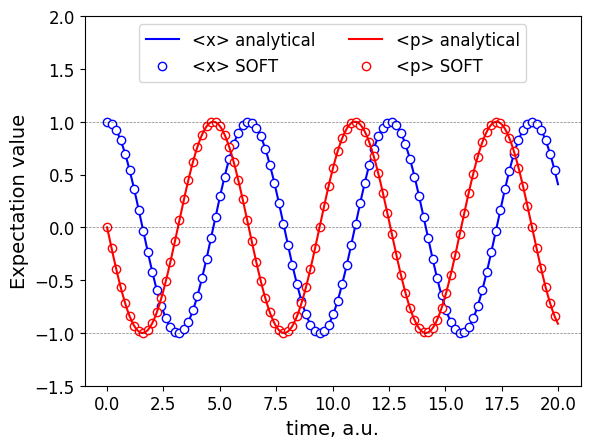

In [12]:
avxgrid_harm_soft = [position_expectation_value(xgrid,propagated_states_harm[i]) for i in range(len(propagated_states_harm))]
dx = xgrid[1]-xgrid[0]
avpgrid_harm_soft = [momentum_expectation_value(dx,pgrid,propagated_states_harm[i]) for i in range(len(propagated_states_harm))]

avxgrid_harm_soft_b = calculate_expectation_values(propagated_states_harm, xgrid)
avpgrid_harm_soft_b = calculate_expectation_values(propagated_states_harm, pgrid, do_FFT=True, dx=dx)

avxgrid_harm_ana = [ x_0*np.cos(omega*t) + (p_0/mass/omega)*np.sin(omega*t) for t in tgrid]
avpgrid_harm_ana = [ -x_0*omega*mass*np.sin(omega*t) + p_0*np.cos(omega*t) for t in tgrid]

fig, ax = plt.subplots()
ax.plot(tgrid, avxgrid_harm_ana, '-', color='blue',label='<x> analytical', zorder=0)
ax.plot(tgrid[::4], avxgrid_harm_soft[::4], 'o', color='blue',label='<x> SOFT', zorder=0, markeredgecolor='blue', fillstyle='full', markerfacecolor='white')
#ax.plot(tgrid[::4], avxgrid_harm_soft_b[::4], 'x', color='k',label='<x> bSOFT', zorder=0, markeredgecolor='blue', fillstyle='full', markerfacecolor='white')
ax.plot(tgrid, avpgrid_harm_ana, '-', color='red',label='<p> analytical')
ax.plot(tgrid[::4], avpgrid_harm_soft[::4], 'o', color='red',label='<p> SOFT', markeredgecolor='red', fillstyle='full', markerfacecolor='white', zorder=0)
#ax.plot(tgrid[::4], avpgrid_harm_soft_b[::4], 'x', color='k',label='<p> bSOFT', zorder=0, markeredgecolor='red', fillstyle='full', markerfacecolor='white')

ax.axhline(-1, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axhline( 0, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axhline( 1, ls='--', lw=0.5, color='black', alpha=0.5)
ax.set_xlabel('time, a.u.', fontsize=14)
ax.set_ylabel('Expectation value', fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-1.5,2)
plt.legend(fontsize=12,loc='upper center', ncol=2)
plt.show()

### SOFT propagation of a coherent state in the double-well potential for A-T DNA base pair

#### Setting up double-well potential for A-T base pair

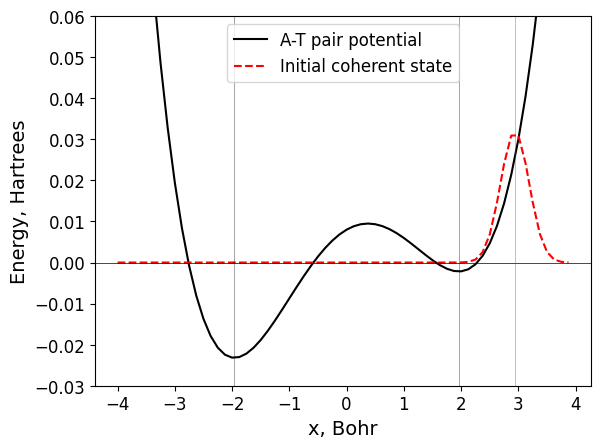

In [13]:
def get_doublewell_potential(x, x0=1.9592, f=ev2au, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    xi = x/x0
    return f*(a0 + a1*xi + a2*xi**2 + a3*xi**3 + a4*xi**4)


def get_doublewell_potential_second_deriv(x, x0=1.9592, f=ev2au, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    return f*(2*a2/x0**2 + 6*a3*x/x0**3 + 12*a4*x**2/x0**4)


x0 = 1.9592
xmin = -4.
xmax = 4.
Nq = 6
N_xpts = 2**Nq

# mass of the proton in units of electron mass
mass = mass_proton

# frequency corresponding to the right well (in atomic units)
omega = np.sqrt(get_doublewell_potential_second_deriv(x0)/mass)

# grid preparation and spacing
xgrid = get_xgrid(xmin, xmax, N_xpts)
pgrid = get_pgrid(xmin, xmax, N_xpts, reorder=True)

dx = xgrid[1] - xgrid[0]
dp = pgrid[1] - pgrid[0]
# operators
Vx_DW = get_doublewell_potential(xgrid)
K_DW = get_kinetic_energy(pgrid, mass)

# initial coherent state in the right well centered at x/x0 = 1.5
x_0 = 1.5*x0
p_0 = 0.0
psi_0 = get_coherent_state(xgrid, p_0, x_0, mass, omega)

# checking potential and initial coherent state
fig, ax = plt.subplots()
ax.plot(xgrid, Vx_DW - get_doublewell_potential(x0) - omega/2, '-',color='black',label='A-T pair potential')
ax.plot(xgrid, 0.02*np.real(get_prob_density(psi_0)),'--',color='red',label='Initial coherent state')
ax.axhline(0, lw=0.5, color='black', alpha=1.0)
ax.axvline(-x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0*1.5, lw=0.5, color='red', alpha=0.5)
ax.set_xlabel('x, Bohr',fontsize=14)
ax.set_ylabel('Energy, Hartrees',fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-0.03,0.06)
plt.legend(fontsize=12,loc='upper center')
plt.show()

#### Time propagation

In [14]:
tmin = 0.0
tmax = 30.0*fs2au
N_tsteps = 3000

# grid preparation and spacing
tgrid = np.linspace(tmin, tmax, N_tsteps)
tau = tgrid[1] - tgrid[0]

print("For ",tmax*au2fs," fs using a timestep of ",tau*au2fs," fs = ",tau," a.u.")

V_prop = get_propagator_on_grid(Vx_DW/2, tau)
K_prop = get_propagator_on_grid(K_DW, tau)

propagated_states = [psi_0]
psi_t = psi_0

for tstep_idx in trange(len(tgrid)):
    psi_t = do_SOFT_propagation(psi_t, K_prop, V_prop)
    propagated_states.append(psi_t)

propagated_states = np.array(propagated_states)[:-1]

For  30.0  fs using a timestep of  0.010003334444814937  fs =  0.4135518506168723  a.u.


  0%|          | 0/3000 [00:00<?, ?it/s]

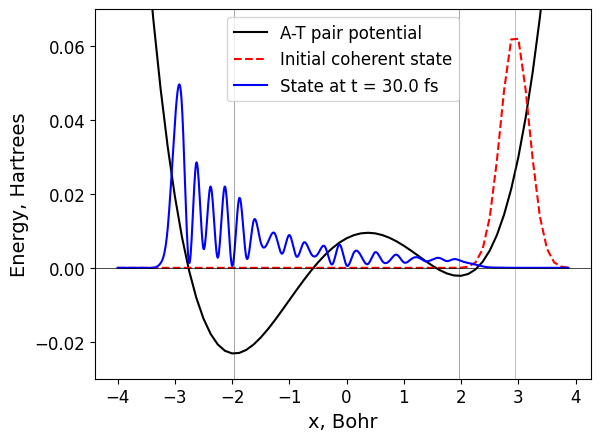

In [15]:
from scipy.interpolate import interp1d

x_1024 = np.linspace(xgrid[0], xgrid[-1], 1024)
f_interp = interp1d(xgrid, get_prob_density(propagated_states[-1]), kind='cubic')
rho_interp = f_interp(x_1024)

fig, ax = plt.subplots()
ax.plot(xgrid, Vx_DW - get_doublewell_potential(x0) - omega/2, '-',color='black',label='A-T pair potential')
ax.plot(xgrid, 0.04*np.real(get_prob_density(psi_0)),'--',color='red',label='Initial coherent state')
#ax.plot(xgrid, 0.04*np.real(get_prob_density(propagated_states[-1])),'-',color='blue',label=f'State at t = {tmax*au2fs} fs')
ax.plot(x_1024, 0.04*rho_interp,'-',color='blue',label=f'State at t = {tmax*au2fs} fs')
ax.axhline(0, lw=0.5, color='black', alpha=1.0)
ax.axvline(-x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0*1.5, lw=0.5, color='red', alpha=0.5)
ax.set_xlabel('x, Bohr',fontsize=14)
ax.set_ylabel('Energy, Hartrees',fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-0.03,0.07)
plt.legend(fontsize=12,loc='upper center')
plt.show()

#### Time evolution of the position expectation value

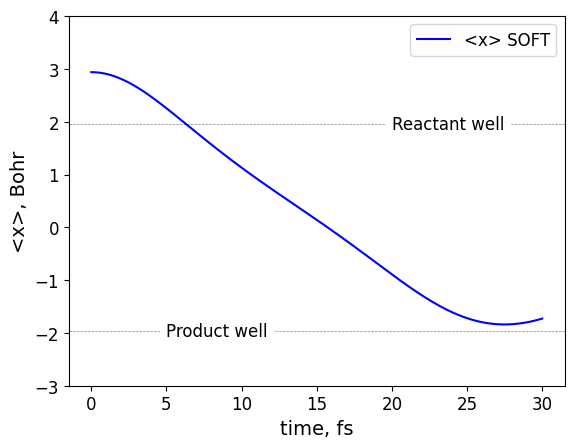

In [16]:
avxgrid = [position_expectation_value(xgrid,propagated_states[i]) for i in range(len(propagated_states))]
avxgrid = calculate_expectation_values(propagated_states, xgrid)
fig, ax = plt.subplots()
ax.plot(tgrid*au2fs, avxgrid, '-', color='blue',label='<x> SOFT')
ax.axhline(-x0, ls='--', lw=0.5, color='black', alpha=0.5)
ax.axhline( x0, ls='--', lw=0.5, color='black', alpha=0.5)
plt.text(20, x0-0.1, 'Reactant well', fontsize = 12, backgroundcolor='white')
plt.text(5, -x0-0.1, 'Product well', fontsize = 12, backgroundcolor='white')
ax.set_xlabel('time, fs', fontsize=14)
ax.set_ylabel('<x>, Bohr', fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-3,4)
plt.legend(fontsize=12,loc='upper right')
plt.show()

# 4. Introduction to Qubit based simulations

In [17]:
!pip install qiskit==1.2.0
!pip install qiskit-ibm-runtime==0.28.0
!pip install qiskit-aer==0.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 6.1 MB/s eta 0:00:00


## 4.1. Quantum Split-Operator Fourier Transform (QSOFT) Method

In [18]:
# Utility Functions/Patches:

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer


def execute(QCircuit, backend=None, shots=None):
    '''
        Function to replace the now-deprecated Qiskit
        `QuantumCircuit.execute()` method.

        Input:
          - `QCircuit`: qiskit.QuantumCircuit object
          - `Backend`: qiskit.Backend instance
          - `shots`: int specifying the number of shots
    '''
    # Transpile circuit with statevector backend
    tmp_circuit = transpile(QCircuit, backend)
    # Run the transpiled circuit
    if shots:
        job = backend.run(tmp_circuit, n_shots=shots)
    else:
        job = backend.run(tmp_circuit)
    return(job)

In [19]:
import scipy.linalg as LA
from qiskit.circuit.library import QFT
from qiskit_aer import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_ibm_runtime import SamplerV2 as Sampler
from tqdm.notebook import trange
np.set_printoptions(linewidth=110)

In [20]:
d = Nq   # number of qubits
mass = 1836.15
x0 = 1.9592
xMin = -4.
xMax =  4.

N = 2**d

# frequency corresponding to the right well (in atomic units)
omega = np.sqrt(get_doublewell_potential_second_deriv(x0)/mass)

# double-well potential
VV = get_doublewell_potential(xgrid) - get_doublewell_potential(x0) - omega/2

In [21]:
# initial coherent state in the right well centered at x/x0 = 1.5
x_0 = 1.5*x0
p_0 = 0.0
psi = get_coherent_state(xgrid, p_0, x_0, mass, omega)*np.sqrt(dx)

In [22]:
# time propagation parameters
tmin = 0.0
tmax = 30.0*fs2au
iterations = 3000

# time grid preparation and spacing
tgrid = np.linspace(tmin, tmax, iterations)
time_step = tgrid[1] - tgrid[0]

# propagators (note that potential energy is divided by two)
VVd_prop = np.diag(np.exp(-1j*VV/2*time_step))
KEd_prop = np.diag(np.exp(-1j*pgrid**2/2/mass*time_step))

In [23]:
# Initialize an Empty Circuit
nqubits = d
q_reg = QuantumRegister(nqubits)
c_reg = ClassicalRegister(nqubits)
qc = QuantumCircuit(q_reg)

qc.initialize(psi, q_reg[:],normalize=True)

# Assemble the circuit for the entire time evolution
for k in trange(iterations):
    bound_op = Operator(VVd_prop)
    qc.append(bound_op, q_reg)
    qc.append(QFT(d,do_swaps=True,inverse=False),q_reg)
    bound_op = Operator(KEd_prop)
    qc.append(bound_op, q_reg)
    qc.append(QFT(d,do_swaps=True,inverse=True),q_reg)
    bound_op = Operator(VVd_prop)
    qc.append(bound_op, q_reg)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [24]:
backend = Aer.get_backend('statevector_simulator')
executed_circuit = execute(qc, backend=backend, shots=1024)

In [25]:
psin = executed_circuit.result().get_statevector().data

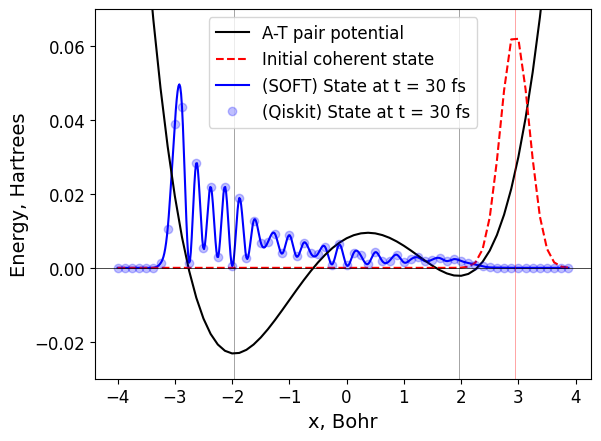

In [26]:
from scipy.interpolate import interp1d

x_dense = np.linspace(xgrid[0], xgrid[-1], 512)
f_interp = interp1d(xgrid, get_prob_density(propagated_states[-1]), kind='cubic')
rho_interp = f_interp(x_dense)

fig, ax = plt.subplots()
ax.plot(xgrid, Vx_DW - get_doublewell_potential(x0) - omega/2, '-',color='black',label='A-T pair potential')
ax.plot(xgrid, 0.04*np.real(get_prob_density(psi_0)),'--',color='red',label='Initial coherent state')
#ax.plot(xgrid, 0.04*np.real(get_prob_density(propagated_states[-1])),'-',color='blue',label='(SOFT) State at t = 30 fs',zorder=0,markeredgecolor='blue',fillstyle='full',markerfacecolor='white')
ax.plot(x_dense, 0.04*rho_interp,'-',color='blue',label='(SOFT) State at t = 30 fs',zorder=0,markeredgecolor='blue',fillstyle='full',markerfacecolor='white')
ax.plot(xgrid, 0.04*np.real(psin.conj()*psin/dx),'o',color='blue',label='(Qiskit) State at t = 30 fs', markevery=1, alpha=0.25)
ax.axhline(0, lw=0.5, color='black', alpha=1.0)
ax.axvline(-x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0*1.5, lw=0.5, color='red', alpha=0.5)
ax.set_xlabel('x, Bohr',fontsize=14)
ax.set_ylabel('Energy, Hartrees',fontsize=14)
ax.tick_params(labelsize=12, grid_alpha=0.5)
plt.ylim(-0.03,0.07)
plt.legend(fontsize=12,loc='upper center')
plt.show()

## 4.6. Quantum Dynamics of the System with Two Spins on an IBM Quantum Computer

In [39]:
J = 1
h0 = -0.5
h1 = 0.5
X = np.array([[0,1],[1,0]], dtype = complex)
Y = np.array([[0,1j],[1j,0]], dtype = complex)
Z = np.array([[1,0],[0,-1]], dtype = complex)
I = np.array([[1,0],[0,1]], dtype = complex)
H = 0.5 * (h0 * np.kron(Z, I) + h1 * np.kron(I, Z)) + J / 4 * (np.kron(X, X) + np.kron(Y, Y) + np.kron(Z, Z))
U = LA.expm(-1j * H)

In [40]:
psi_init = np.array([1,0,0,0],dtype = complex)
psi_fin = U @ psi_init

In [41]:
qreg=QuantumRegister(2) # qreg is filled with two qubits
creg=ClassicalRegister(2, name='creg') # creg is filled with two classical bits
entangler=QuantumCircuit(qreg,creg) # we put together our qreg and creg to make our Quantum Circuit, called entangler here.
#entangler.initialize(psi_init)  #Not necessary since we start at |00>

In [42]:
U_gate = Operator(U)
entangler.append(U_gate,[0,1])

In [43]:
entangler.measure(0,0) # measure the first qubit and record it in the first classical bit
entangler.measure(1,1)

In [44]:
entangler.draw()

┌──────────┐┌─┐   
  q4_0: ┤0         ├┤M├───
        │  Unitary │└╥┘┌─┐
  q4_1: ┤1         ├─╫─┤M├
        └──────────┘ ║ └╥┘
creg: 2/═════════════╩══╩═
                     0  1

In [47]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.exceptions import IBMNotAuthorizedError

MY_API_TOKEN = "INSERT_YOUR_API_TOKEN_HERE"

try:
    # Save an IBM Quantum account.
    # https://docs.quantum.ibm.com/api/qiskit-ibm-runtime
    service = QiskitRuntimeService.save_account(channel="ibm_quantum", token=MY_API_TOKEN,
                                                instance='ibm-q/open/main', overwrite=True)
    use_IBMQ = True
except IBMNotAuthorizedError as error:
    use_IBMQ = False
    print('No API token provided')
    pass


In [49]:
use_IBMQ = False

In [50]:
if use_IBMQ:
    service = QiskitRuntimeService()
    # Run the sampler job locally using FakeManilaV2
    backend = FakeManilaV2()
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    entangler_circuit = pm.run(entangler)

    sampler = Sampler(mode=backend)
    sampler.options.default_shots = 1024  # Options can be set using auto-complete.
    job = sampler.run([entangler_circuit])
    pub_result = job.result()[0]
    result_dict = pub_result.data.creg.get_counts()

In [51]:
if use_IBMQ:
    real_result = np.zeros((4,))
    for idx,k  in enumerate(result_dict.keys()):
        real_result[idx] = result_dict[k]
    print("Using FakeManilaV2!")
    print("Counts for the classical output register:")
    print(real_result)

In [52]:
if use_IBMQ:
    backend = service.least_busy(operational=True, simulator=False)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    entangler_circuit = pm.run(entangler)

    sampler = Sampler(mode=backend)
    sampler.options.default_shots = 1024
    job = sampler.run([entangler_circuit])
    print(f"Job ID is {job.job_id()}")
    pub_result = job.result()[0]
    result_dict = pub_result.data.creg.get_counts()

    real_result = np.zeros((4,))
    for idx,k  in enumerate(result_dict.keys()):
        real_result[idx] = result_dict[k]
    print("Counts for the classical output register creg:")
    print(real_result)

## 4.7. Simulating a Hamiltonian Expressed in the Basis of Pauli Matrices

In [53]:
from qiskit.quantum_info import SparsePauliOp


def get_hamiltonian_n_site_terms(n, coeff, n_qubits):
    '''
        Assembles each term in the Hamiltonian based on their Pauli string
        representation and multiplying by the respective coefficient.
    '''
    XX_coeff = coeff[0]
    YY_coeff = coeff[1]
    ZZ_coeff = coeff[2]
    Z_coeff = coeff[3]

    XX_term = SparsePauliOp(("I" * n + "XX" + "I" * (n_qubits - 2 - n)))
    XX_term *= XX_coeff
    YY_term = SparsePauliOp(("I" * n + "YY" + "I" * (n_qubits - 2 - n)))
    YY_term *= YY_coeff
    ZZ_term = SparsePauliOp(("I" * n + "ZZ" + "I" * (n_qubits - 2 - n)))
    ZZ_term *= ZZ_coeff
    Z_term = SparsePauliOp(("I" * n + "Z" + "I" * (n_qubits - 1 - n)))
    Z_term *= Z_coeff

    return (XX_term + YY_term + ZZ_term + Z_term)

In [54]:
def get_heisenberg_hamiltonian(n_qubits, coeff=None):
    '''
        Takes an integer number corresponding to number of spins/qubits
        and a list of sublists containing the necessary coefficients
        to assemble the complete Hamiltonian:

            H = \sum _i ^N h_z Z_i
                + \sum _i ^{N-1} (h_xx X_iX_{i+1}
                                  + h_yy Y_iY_{i+1}
                                  + h_zz Z_iZ_{i+1}
                                 )

        Each sublist contains the [XX, YY, ZZ, Z] coefficients in this order.
        The last sublist should have the same shape, but only the Z component
        is used.
        If no coefficient list is provided, all are set to 1.
    '''

    # Three qubits because for 2 we get H_O = 0
    assert n_qubits >= 3

    if coeff == None:
        'Setting default values for the coefficients'
        coeff = [[1.0, 1.0, 1.0, 1.0] for i in range(n_qubits)]

    # Even terms of the Hamiltonian
    # (summing over individual pair-wise elements)
    H_E = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits)
               for i in range(0, n_qubits-1, 2)))

    # Odd terms of the Hamiltonian
    # (summing over individual pair-wise elements)
    H_O = sum((get_hamiltonian_n_site_terms(i, coeff[i], n_qubits)
               for i in range(1, n_qubits-1, 2)))

    # adding final Z term at the Nth site
    final_term = SparsePauliOp("I" * (n_qubits - 1) + "Z")
    final_term *= coeff[n_qubits-1][3]
    if (n_qubits % 2) == 0:
        H_E += final_term
    else:
        H_O += final_term

    # Returns the list of the two sets of terms
    return [H_E, H_O]

In [55]:
num_q = 3
# XX YY ZZ, Z
ham_coeffs = ([[0.75/2, 0.75/2, 0.0, 0.65]]
                + [[0.5, 0.5, 0.0, 1.0]
                for i in range(num_q-1)])

spin_chain_hamiltonian = get_heisenberg_hamiltonian(num_q,
                                                    ham_coeffs)
print('Hamiltonian separated into even and odd components:')
print(spin_chain_hamiltonian)
print('Hamiltonian combining even and odd components:')
print(sum(spin_chain_hamiltonian))

Hamiltonian separated into even and odd components:
[SparsePauliOp(['XXI', 'YYI', 'III', 'ZII'],
              coeffs=[0.375+0.j, 0.375+0.j, 0.   +0.j, 0.65 +0.j]), SparsePauliOp(['IXX', 'IYY', 'III', 'IZI', 'IIZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0. +0.j, 1. +0.j, 1. +0.j])]
Hamiltonian combining even and odd components:
SparsePauliOp(['XXI', 'YYI', 'III', 'ZII', 'IXX', 'IYY', 'III', 'IZI', 'IIZ'],
              coeffs=[0.375+0.j, 0.375+0.j, 0.   +0.j, 0.65 +0.j, 0.5  +0.j, 0.5  +0.j, 0.   +0.j, 1.   +0.j, 1.   +0.j])


In [56]:
from qiskit.circuit.library import PauliEvolutionGate
# Trotter-Suzuki implementation for decomposition of exponentials
# of matrices
from qiskit.synthesis import SuzukiTrotter
from qiskit import QuantumCircuit, QuantumRegister
import numpy as np
from itertools import groupby
import re

def get_time_evolution_operator(num_qubits, tau, trotter_steps, coeff=None):
    '''
        Given a number of qubits, generates the corresponding time-evolution for
        the Ising model with the same number of sites.

        Input:
            num_qubits (int): number of qubits, which should be equal to the
                number of spins in the chain
            evo_time (float): time parameter in time-evolution operator
            trotter_steps (int): number of time steps for the Suzuki-Trotter
                decomposition
            coeff (list of lists): parameters for each term in the Hamiltonian
                for each site ie ([[XX0, YY0, ZZ0, Z0], [XX1, YY1, ZZ1, Z1], ...])
        Returns:
            evo_op.definition: Trotterized time-evolution operator
    '''
    # Constructing the Hamiltonian here;
    # heisenberg_hamiltonian = [H_E, H_O]
    heisenberg_hamiltonian = get_heisenberg_hamiltonian(num_qubits,
                                                        coeff)

    # e^ (-i*H*evo_time), with Trotter decomposition
    # exp[(i * evo_time)*(IIIIXXIIII + IIIIYYIIII + IIIIZZIIII + IIIIZIIIII)]
    evo_op = PauliEvolutionGate(heisenberg_hamiltonian, tau,
                                synthesis=SuzukiTrotter(order=2,
                                    reps=trotter_steps))
    # The Trotter order=2 applies one set of the operators for
    # half a timestep, then the other set for a full timestep,
    # then the first step for another half a step note that reps
    # includes the number of repetitions of the Trotterized
    # operator higher number means more repetitions, and thus
    # allowing larger timestep
    return evo_op.definition

num_shots = 100
num_q = 3
evolution_timestep = 0.1
n_trotter_steps = 1
# XX YY ZZ, Z
ham_coeffs = ([[0.75/2, 0.75/2, 0.0, 0.65]]
                + [[0.5, 0.5, 0.0, 1.0]
                for i in range(num_q-1)])
time_evo_op = get_time_evolution_operator(
    num_qubits=num_q, tau=evolution_timestep,
    trotter_steps=n_trotter_steps, coeff=ham_coeffs)

In [57]:
def find_string_pattern(pattern, string):
    match_list = []
    for m in re.finditer(pattern, string):
        match_list.append(m.start())
    return match_list


def sort_Pauli_by_symmetry(ham):
    '''
        Separates a qiskit PauliOp object terms into 1 and 2-qubit
        operators. Furthermore, 2-qubit operators are separated according
        to the parity of the index first non-identity operation.
    '''
    one_qubit_terms = []
    two_qubit_terms = []
    # separating the one-qubit from two-qubit terms
    for term in ham:
        matches = find_string_pattern('X|Y|Z', str(term.paulis[0]))
        pauli_string = term.paulis[0]
        coeff = np.real(term.coeffs[0])
        str_tag = pauli_string.to_label().replace('I', '')
        if len(matches) == 2:
            two_qubit_terms.append((pauli_string, coeff, matches, str_tag))
        elif len(matches) == 1:
            one_qubit_terms.append((pauli_string, coeff, matches, str_tag))

    # sorting the two-qubit terms according to index on which they act
    two_qubit_terms = sorted(two_qubit_terms, key=lambda x: x[2])
    # separating the even from the odd two-qubit terms
    even_two_qubit_terms = list(filter(lambda x: not x[2][0]%2, two_qubit_terms))
    odd_two_qubit_terms = list(filter(lambda x: x[2][0]%2, two_qubit_terms))

    even_two_qubit_terms = [list(v) for i, v in groupby(even_two_qubit_terms, lambda x: x[2][0])]
    odd_two_qubit_terms = [list(v) for i, v in groupby(odd_two_qubit_terms, lambda x: x[2][0])]

    return one_qubit_terms, even_two_qubit_terms, odd_two_qubit_terms

In [58]:
def generate_circ_pattern_1qubit(circ, term, delta_t):
    '''
        General 1-qubit gate for exponential of product identity and
        a single pauli gate.
        Only a single rotation operation is required, with the angle
        being related to the exponential argument:

        R_P(coeff) = exp(-i * coeff * P / 2)

        Where P is the Pauli gate and coeff encompasses the constant
        coefficient term
    '''
    coeff = 2 * term[1] * delta_t
    if term[3] == 'X':
        circ.rx(coeff, term[2])
    elif term[3] == 'Y':
        circ.ry(coeff, term[2])
    elif term[3] == 'Z':
        circ.rz(coeff, term[2])

    return circ


In [59]:
def generate_circ_pattern_2qubit(circ, term, delta_t):
    '''
        General 2-qubit gate for exponential of Paulis. This is the
        optimal decomposition, based on a component of a U(4) operator.
        (see )

        The circuit structure is as follows:

        - ---- I ---- C - Rz(o) - X --- I --- C - Rz(pi/2) -
        - Rz(-pi/2) - X - Ry(p) - C - Ry(l) - X ---- I -----

        Where CX represent CNOT operations, R are rotation gates with angles,
        and I is the identity matrix. The angles are parameterized as follows:

        o = \theta = (\pi/2 - A)
        p = \phi = (A - \pi/2)
        l = \lambda = (\pi/2 - A)

        Where A is the exponential argument.
    '''
    # wires to which to apply the operation
    wires = term[0][2]

    # angles to parameterize the circuit,
    # based on exponential argument
    if any('XX' in sublist for sublist in term):
        g_phi = ( 2 * (-1) * term[0][1] * delta_t - np.pi / 2)
    else:
        g_phi = - np.pi / 2
    if any('YY' in sublist for sublist in term):
        g_lambda = (np.pi/2 - 2 * (-1) * term[1][1] * delta_t)
    else:
        g_lambda = np.pi/2
    if any('ZZ' in sublist for sublist in term):
        g_theta = (np.pi/2 - 2 * (-1) * term[2][1] * delta_t)
    else:
        g_theta = np.pi/2

    # circuit
    circ.rz(-np.pi/2, wires[1])
    circ.cx(wires[1], wires[0])
    circ.rz(g_theta, wires[0])
    circ.ry(g_phi, wires[1])
    circ.cx(wires[0], wires[1])
    circ.ry(g_lambda, wires[1])
    circ.cx(wires[1], wires[0])
    circ.rz(np.pi/2, wires[0])
    return circ

In [60]:
def get_manual_Trotter(num_q, pauli_ops, timestep, n_trotter=1,
                       trotter_type='basic', reverse_bits=True):
    # sorts the Pauli strings according to qubit number they affect and symmetry
    one_q, even_two_q, odd_two_q = sort_Pauli_by_symmetry(pauli_ops)
    # scales the timestep according to the number of trotter steps
    timestep_even_two_q = timestep / n_trotter
    timestep_odd_two_q = timestep / n_trotter
    timestep_one_q = timestep / n_trotter
    # symmetric places 1/2 of one_q and odd_two_q before and after even_two_q
    if trotter_type == 'symmetric':
        timestep_odd_two_q /= 2
        timestep_one_q /= 2
    # constructs circuits for each segment of the operators
    qc_odd_two_q, qc_even_two_q, qc_one_q = QuantumCircuit(num_q), QuantumCircuit(num_q), QuantumCircuit(num_q)
    for i in even_two_q:
        qc_even_two_q = generate_circ_pattern_2qubit(qc_even_two_q, i, timestep_even_two_q)
    for i in odd_two_q:
        qc_odd_two_q = generate_circ_pattern_2qubit(qc_odd_two_q, i, timestep_odd_two_q)
    for i in one_q:
        qc_one_q = generate_circ_pattern_1qubit(qc_one_q, i, timestep_one_q)
    # assembles the circuit for Trotter decomposition of exponential
    qr = QuantumRegister(num_q)
    qc = QuantumCircuit(qr)
    if trotter_type == 'basic':
        qc = qc.compose(qc_even_two_q)
        qc = qc.compose(qc_odd_two_q)
        qc = qc.compose(qc_one_q)
    elif trotter_type == 'symmetric':
        qc = qc.compose(qc_one_q)
        qc = qc.compose(qc_odd_two_q)
        qc = qc.compose(qc_even_two_q)
        qc = qc.compose(qc_odd_two_q)
        qc = qc.compose(qc_one_q)
    # repeats the single_trotter circuit several times to match n_trotter
    for i in range(n_trotter-1):
        qc = qc.compose(qc)
    if reverse_bits:
        return qc.reverse_bits()
    else:
        return qc

In [61]:
spin_chain_hamiltonian = get_heisenberg_hamiltonian(num_q,
                                                    ham_coeffs)

spin_chain_hamiltonian = sum(spin_chain_hamiltonian)
print(get_manual_Trotter(num_q, spin_chain_hamiltonian,
                            0.1).draw())
print(get_manual_Trotter(num_q, spin_chain_hamiltonian, 0.1,
                            n_trotter=2).draw())
print(get_manual_Trotter(num_q, spin_chain_hamiltonian, 0.1,
                            trotter_type='symmetric').draw())
print(get_manual_Trotter(num_q, spin_chain_hamiltonian, 0.1,
                            n_trotter=2,
                            trotter_type='symmetric').draw())

      ┌──────────┐                                                       »
q5_0: ┤ Rz(-π/2) ├─────────────────────────────────────────────────■─────»
      ├──────────┤     ┌─────────────┐┌───┐┌────────────┐        ┌─┴─┐   »
q5_1: ┤ Rz(-π/2) ├──■──┤ Ry(-1.6458) ├┤ X ├┤ Ry(1.6458) ├──■─────┤ X ├───»
      └──────────┘┌─┴─┐└─┬─────────┬─┘└─┬─┘└────────────┘┌─┴─┐┌──┴───┴──┐»
q5_2: ────────────┤ X ├──┤ Rz(π/2) ├────■────────────────┤ X ├┤ Rz(π/2) ├»
                  └───┘  └─────────┘                     └───┘└─────────┘»
«      ┌─────────────┐┌───┐┌────────────┐     ┌─────────┐           
«q5_0: ┤ Ry(-1.6708) ├┤ X ├┤ Ry(1.6708) ├──■──┤ Rz(0.2) ├───────────
«      └─┬─────────┬─┘└─┬─┘└────────────┘┌─┴─┐├─────────┤┌─────────┐
«q5_1: ──┤ Rz(π/2) ├────■────────────────┤ X ├┤ Rz(π/2) ├┤ Rz(0.2) ├
«        ├─────────┴┐                    └───┘└─────────┘└─────────┘
«q5_2: ──┤ Rz(0.13) ├───────────────────────────────────────────────
«        └──────────┘                                        

In [62]:
# used to compile the circuit, tranpiling to the set of
# operations supported by the device backend and execution
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import transpile

# specifying a quantum register with specific number of qubits
qr = QuantumRegister(num_q)
# classical register used for measurement of qubits
cr = ClassicalRegister(num_q)
# quantum circuit combining quantum and classical registers
qc = QuantumCircuit(qr, cr) # instantiated here
qc.draw(style='iqp')
print(qc)

# specifying initial state by flipping qubit states
for qubit_idx in range(num_q):
    if qubit_idx == 0:
        # generate only one spin-up at first qubit
        qc.id(qubit_idx)
    else:
        # make all other spins have the spin-down state
        qc.x(qubit_idx)
qc.barrier()
qc.draw(style='iqp')
print(qc)

# checking the initial state
device = Aer.get_backend('statevector_simulator')
qc_init_state = execute(qc, backend=device).result()
qc_init_state = qc_init_state.get_statevector()
print(qc_init_state)

# generating the time evolution operator for a specific set of
# hamiltonian parameters and timestep
time_evo_op = get_time_evolution_operator(num_qubits=num_q,
        tau=evolution_timestep,
        trotter_steps=n_trotter_steps,
        coeff=ham_coeffs)

# appending the Hamiltonian evolution to the circuit
qc.append(time_evo_op, list(range(num_q)))
qc.barrier()
qc.draw(style='iqp')
print(qc)

# Depth check
print('Depth of the circuit is', qc.depth())
# transpiled circuit to statevector simulator
qct = transpile(qc, device, optimization_level=2)
qct.decompose().decompose()
qct.draw(style='iqp')
print(qct)

print('Depth of the circuit after transpilation is '
        f'{qct.depth()}')

# showcasing simple execution
qct_run = execute(qct, device, shots=1270).result()
qct_run_counts = qct_run.get_counts()
print(f'Circuit measurement counts {qct_run_counts}')

      
q9_0: 
      
q9_1: 
      
q9_2: 
      
c1: 3/
      
      ┌───┐ ░ 
q9_0: ┤ I ├─░─
      ├───┤ ░ 
q9_1: ┤ X ├─░─
      ├───┤ ░ 
q9_2: ┤ X ├─░─
      └───┘ ░ 
c1: 3/════════
              
Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2, 2))
      ┌───┐ ░ ┌───────────────────┐ ░ 
q9_0: ┤ I ├─░─┤0                  ├─░─
      ├───┤ ░ │                   │ ░ 
q9_1: ┤ X ├─░─┤1 circuit-27198**1 ├─░─
      ├───┤ ░ │                   │ ░ 
q9_2: ┤ X ├─░─┤2                  ├─░─
      └───┘ ░ └───────────────────┘ ░ 
c1: 3/════════════════════════════════
                                      
Depth of the circuit is 2
            ░                                 ┌───────────┐┌───────────┐»
q9_0: ──────░─────────────────────────────────┤0          ├┤0          ├»
      ┌───┐ ░ ┌──────────────┐┌──────────────┐│  Rxx(0.1) ││  Ryy(0.1) │»
q9_1: ┤ X ├─░─┤0             ├┤0             ├┤1          ├┤1          ├»
      ├───┤ ░ │  Rxx(0.

In [63]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
qr = QuantumRegister(num_q)
cr = ClassicalRegister(num_q)
qc = QuantumCircuit(qr, cr) # instantiated here

In [64]:
for qubit_idx in range(num_q):
    if qubit_idx == 0:
        # generate only one spin-up at first qubit
        qc.id(qubit_idx)
    else:
        # make all other spins have the spin-down state
        qc.x(qubit_idx)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import Aer


# Quantum circuit for propagation
def qsolve_statevector(psin, qc):
    '''
        Performs dynamical propagation for a specific quantum circuit, using the
        an initial state equal to the result of the prior iteration. In effect,
        this propagates:

        | \psi _t \rangle  = e^{i*\tau*H/hbar} e^{i*\tau*H/hbar} ... | \psi _0 \rangle
        -> | \psi _t \rangle  = e^{i*\tau*H/hbar} | \psi _{t-\tau} \rangle

        Use of reinitialization in this way is possible due to the usage of the
        statevector_simulator backend; this may not be practical for an
        implementation on actual hardware.
        Returns:
            psin (statevector): final statevector after execution
    '''
    # Determining number of qubits from the length of the state vector
    n=np.size(psin)
    d=int(np.log2(np.size(psin)))
    # Circuit preparation
    qre = QuantumRegister(d)
    circ = QuantumCircuit(qre)
    circ.initialize(psin,qre)
    circ.barrier()
    # for i in range(0,100):
    circ.append(qc, qre)
    circ.barrier()
    # Circuit execution
    device = Aer.get_backend('statevector_simulator')
    psin = execute(circ, backend=device).result()
    psin = psin.get_statevector()
    return psin

In [66]:
qc.draw()

┌───┐
q10_0: ┤ I ├
       ├───┤
q10_1: ┤ X ├
       ├───┤
q10_2: ┤ X ├
       └───┘
 c2: 3/═════

[0 0 0 1 0 0 0 0]


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-67-744437531>:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


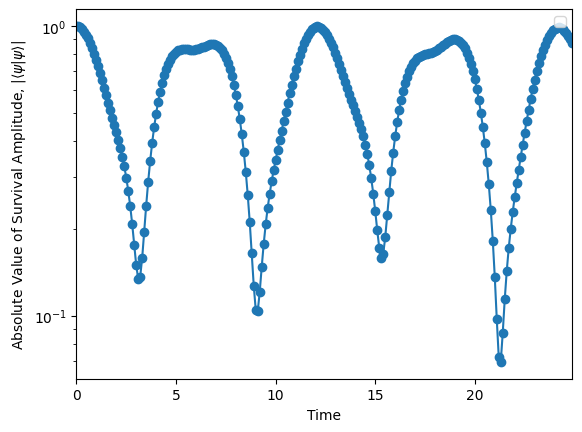

In [67]:
# Qubit basis states
zero_state = np.array([[1],[0]])
one_state = np.array([[0],[1]])

# For a 011 initial state prepare as follows
psin = zero_state # for the first spin
# iterates over the remaining spins, by performing
# Kronecker Product
for i in range(num_q-1):
    psin = np.kron(psin, one_state)
psin0 = psin.flatten()
print(psin0)

# time evolution operator
time_evo_op = get_time_evolution_operator(num_qubits=num_q,
        tau=evolution_timestep,
        trotter_steps=n_trotter_steps,
        coeff=ham_coeffs)
# number of steps for which to propagate
# (totaling 25 units of time)
nsteps = 250
psin_list = []
psin_list.append(psin0)
correlation_list = []
# performs dynamical propagation by statevector re-initialization
for k in trange(nsteps):
    #print(f'Running dynamics step {k}')
    if k > 0:
        psin = qsolve_statevector(psin_list[-1], time_evo_op)
        # removes the last initial state to save memory
        psin_list.pop()
        # stores the new initial state
        psin_list.append(psin)
    correlation_list.append(np.vdot(psin_list[-1],psin0))

time = np.arange(0, evolution_timestep*(nsteps),
                 evolution_timestep)
np.save(f'{num_q}_spin_chain_time', time)
sa_observable = np.abs(correlation_list)
np.save(f'{num_q}_spin_chain_SA_obs', sa_observable)
# plotting
plt.plot(time, sa_observable, '-o')
plt.xlabel('Time')
plt.ylabel('Absolute Value of Survival Amplitude, '
           r'$\left|\langle \psi | \psi \rangle \right|$')
plt.xlim((min(time), max(time)))
plt.yscale('log')
plt.legend()
plt.show()

## 4.8. Encoding an arbitrary Hamiltonian in the basis of Pauli matrices

In [68]:
import itertools


def vec_query(arr, my_dict):
    '''
    This function vectorizes dictionary querying.
    It allows us to query `my_dict` with a np.array `arr` of keys.
    This avoids a loop through the list of keys.
    '''
    return np.vectorize(my_dict.__getitem__, otypes=[tuple])(arr)

def nested_kronecker_product(a):
    '''
    Handles Kronecker Products for list (i.e., a = [Z, Z, Z] will evaluate Z Z Z).
    Given list `a` this recursively evaluates the kronecker product of all elements.
    This allows us to avoid having to call `np.kron` n-1 times for a list of length n.
    '''
    if len(a) == 2:
        return np.kron(a[0],a[1])
    else:
        return np.kron(a[0], nested_kronecker_product(a[1:]))

def Hilbert_Schmidt(mat1, mat2):
    '''
    Return the Hilbert-Schmidt Inner Product of two matrices.
    This gives the coefficients for each term in the sum of tensor products of Paulis.
    '''
    return np.trace(mat1 * mat2)

def decompose(Ham_arr, tol=10):
    '''
    Function that decomposes `Ham_arr` into a sum of Pauli strings.
    '''

    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,complex(0,-1)],[complex(0,1),0]])
    Z = np.array([[1,0],[0,-1]])
    I = Z@Z
    # Define a dictionary with the four Pauli matrices:
    pms = {'I': I,'X': X,'Y': Y,'Z': Z}
    pauli_keys = list(pms.keys()) # Keys of the dictionary

    nqb = int(np.log2(Ham_arr.shape[0])) # Determine the # of qubits needed

    # Make all possible tensor products of Pauli matrices sigma
    sigma_combinations = list(itertools.product(pauli_keys, repeat=nqb))

    output_string = '' # Initialize an empty string to which we can add our terms
    for ii in range(len(sigma_combinations)):
        pauli_str = ''.join(sigma_combinations[ii])

        # Convert the Pauli string into a list of matrices
        tmp_mat_list = vec_query(np.array(sigma_combinations[ii]), pms)

        # Evaluate the Kronecker product of the matrix array
        tmp_p_matrix = nested_kronecker_product(tmp_mat_list)

        # Compute the coefficient for each Pauli string
        a_coeff = (1/(2**nqb)) * Hilbert_Schmidt(tmp_p_matrix, Ham_arr)

        # If the coefficient is non-zero, we want to use it!
        if abs(a_coeff) > 10**(-tol):
            output_string += str(np.round(a_coeff.real, 6))+'*'+pauli_str
            output_string += '+' # Add a plus sign for the next term!

    return output_string[:-1] # To ignore that extra plus sign

## 4.9. Using the Hadamard Test for Calculating Expectation Values

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import Aer
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister


def get_hadamard_test(num_q, initial_state, control_operation,
                      control_repeats=0, imag_expectation=False):
    '''
        Writes the Hadamard test circuit to evaluate the real (or imaginary)
        components of a given operator (or set of operators) by measuring the
        ancilla.

        Inputs:
            num_qubits (int): number of qubits needed for the calculation
            initial_state: quantum circuit object containing the initialization
                for the system
            control_operation: quantum circuit object containing the controlled
                version of the unitary operator for which to evaluate the
                expectation value
            control_repeats (int): number of repetitions of the controlled
                operation in the Hadamard test circuit (such as time-propagation)
            imag_expectation (boolean): whether to assemble the circuit for
                evaluation of the real or imaginary components of the operator.
        Returns:
            qc_hadamard: quantum circuit object containing the hadamard test
    '''
    # Circuit object framework
    qr_hadamard = QuantumRegister(num_q+1)
    cr_hadamard = ClassicalRegister(1)
    qc_hadamard = QuantumCircuit(qr_hadamard, cr_hadamard) # instantiated here
    # Initialization of calculation qubits
    qc_hadamard.append(initial_state, qr_hadamard[1:]) # initial psi
    qc_hadamard.barrier()
    # Hadamard test structure
    qc_hadamard.h(0)
    if imag_expectation:
        qc_hadamard.p(-np.pi/2, 0) # qc_hadamard.s(0).inverse() may be equivalent
    # iterates over the number of times the control operation should be added
    for i in range(control_repeats):
        qc_hadamard.append(control_operation, qr_hadamard[:])
    qc_hadamard.h(0)
    qc_hadamard.barrier()
    # Measuring the ancilla
    qc_hadamard.measure(0,0)
    return qc_hadamard


def get_circuit_execution_counts(qc, backend, n_shots=100):
    '''
        Takes a quantum circuit, Qiskit supported backend and a specified number
        of execution times to calculate the number of times each state in the
        circuit was measured.

        Inputs:
            qc: Qiskit quantum circuit object
            backend: qiskit supported quantum computer framework (either simulator
                or actual device)
                n_shots (int): default=100; number of times for which to execute
                    the circuit using the specified backend.
    '''
    qc_execution = execute(qc, backend, shots=n_shots)
    counts = qc_execution.result().get_counts()
    return counts # number of times measured 0 and 1


def get_spin_correlation(counts):
    '''
        Generates the spin correlation at a particular time by averaging over
        the counts of the ancillary qubit.
    '''

    qubit_to_spin_map = {
        '0': 1,
        '1': -1,
    }
    total_counts = 0
    values_list = []
    for k,v in counts.items():
        values_list.append(qubit_to_spin_map[k] * v)
        total_counts += v
    # print(values_list)
    average_spin = (sum(values_list)) / total_counts
    return average_spin


def get_initialization(num_qubits, initialization_string):
    '''
        Creates a circuit containing the qubit initialization for a specified
        number of qubits and given initialization string. There are alternative
        methods to initialize the circuit besides the one used in this function
        including using a statevector or amplitude embedding of an arbitrary state.
    '''
    qr_init = QuantumRegister(num_qubits)
    qc_init = QuantumCircuit(qr_init)
    qc_init.initialize(initialization_string, qr_init[:]) # 0x1x1
    return qc_init

                                                                             »
q881: ───────■───────────────■───────────────■──────────■────────────────────»
      ┌──────┴───────┐       │               │          │                    »
 q_0: ┤ U(π/2,0,π,0) ├───────┼───────────────┼──────────┼────────────────────»
      └──────────────┘┌──────┴───────┐       │          │                    »
 q_1: ────────────────┤ U(π/2,0,π,0) ├───────┼──────────■────────────────────»
                      └──────────────┘┌──────┴───────┐┌─┴─┐┌────────────────┐»
 q_2: ────────────────────────────────┤ U(π/2,0,π,0) ├┤ X ├┤ U(0,0,0.01875) ├»
                                      └──────────────┘└───┘└────────────────┘»
«                                                         ┌──────┐      »
«q881: ──■───────────────────────■────■─────────■─────────┤ P(0) ├───■──»
«        │                       │    │         │         └──────┘   │  »
« q_0: ──┼───────────────────────┼────┼─────────┼──────────────────

FileNotFoundError: [Errno 2] No such file or directory: 'data/3_spin_chain_SA_obs.npy'

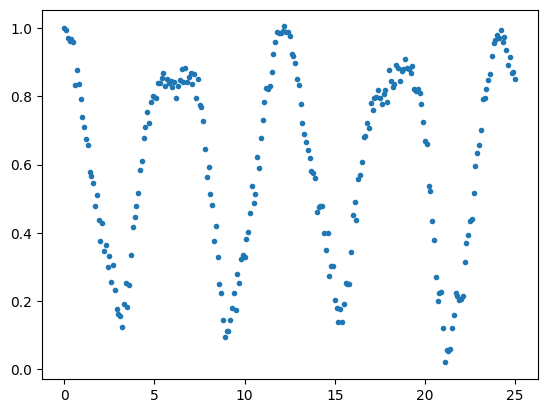

In [ ]:
# switch this variable to True to execution the 'for' loop.
# it takes >1hr for 3 spins, with the parameters defined above
# and 1000 shots for each time step.
# run_hadamard_test_boolean = False
run_hadamard_test_boolean = True

# IMPORTANT: Use qasm_simulator to obtain meaningful statistics
# statevector is not appropriate for this method
simulator = Aer.get_backend('qasm_simulator')

num_q = 3
n_trotter_steps = 1
# XX YY ZZ, Z
hamiltonian_coefficients = ([[0.75/2, 0.75/2, 0.0, 0.65]]
                            + [[0.5, 0.5, 0.0, 1.0]
                                for i in range(num_q-1)])

num_shots = 100 # increase to check for convergence

evolution_timestep=0.1
total_time = 25
time_range = np.arange(0, total_time+evolution_timestep,
                       evolution_timestep)


# time evolution operator
time_evo_op = get_time_evolution_operator(num_qubits=num_q,
        tau=evolution_timestep,
        trotter_steps=n_trotter_steps,
        coeff=hamiltonian_coefficients)
# for closed controlled operation (ie if qubit is 1)
controlled_time_evo_op = time_evo_op.control()
# for open controlled operation (ie if qubit is 0);
# not used here for this correlation fxn but needed for others
# controlled_time_evo_op = time_evo_op.control(ctrl_state=0)
print(controlled_time_evo_op.decompose())


init_state_list = '1' + '0' * (num_q-1)
init_circ = get_initialization(num_q, init_state_list)
init_circ.draw(style='iqp')
print(init_circ)

# lists t store observables
if run_hadamard_test_boolean:
    real_amp_list = []
    imag_amp_list = []
    for idx,time in enumerate(time_range):
        print(f'Running dynamics step {idx}')
        # Real component ------------------------------
        qc_had_real = get_hadamard_test(num_q, init_circ,
                                        controlled_time_evo_op,
                                        control_repeats=idx,
                                        imag_expectation=False)
        had_real_counts = get_circuit_execution_counts(
                qc_had_real, simulator, n_shots=num_shots)
        real_amplitude = get_spin_correlation(had_real_counts)
        real_amp_list.append(real_amplitude)

        # Imag component ------------------------------
        qc_had_imag = get_hadamard_test(num_q, init_circ,
                                        controlled_time_evo_op,
                                        control_repeats=idx,
                                        imag_expectation=True)
        had_imag_counts = get_circuit_execution_counts(
                qc_had_imag, simulator, n_shots=num_shots)
        imag_amplitude = get_spin_correlation(had_imag_counts)
        imag_amp_list.append(imag_amplitude)
        print(f'Finished step {idx}, where '
              f'Re = {real_amplitude:.3f} '
              f'Im = {imag_amplitude:.3f}')

    real_amp_array = np.array(real_amp_list)
    imag_amp_array = np.array(imag_amp_list)

    print('Saving data...')
    # real and imaginary amplitude components
    np.savetxt('real_amp_array.csv', real_amp_array,
               fmt='%.18e', delimiter=';', newline='\n')
    np.savetxt('imag_amp_array.csv', imag_amp_array,
               fmt='%.18e', delimiter=';', newline='\n')
    # survival amplitude
    np.savetxt('np_abs_correlation_with_hadamard_test.csv',
               np.abs(real_amp_array + 1j*imag_amp_array),
               fmt='%.18e', delimiter=';', newline='\n')
    # survival probability
    np.savetxt('np_sqrt_sum_squares_correlation_with_hadamard'
               '_test.csv',
               np.sqrt(real_amp_array**2 + imag_amp_array**2),
               fmt='%.18e', delimiter=';', newline='\n')
real_amp_array = np.loadtxt('real_amp_array.csv',
                            delimiter=';')
imag_amp_array = np.loadtxt('imag_amp_array.csv',
                            delimiter=';')
np_abs_correlation_with_hadamard_test = np.loadtxt(
        'np_abs_correlation_with_hadamard_test.csv',
        delimiter=';')
np_sqrt_sum_squares_correlation_with_hadamard_test = np.loadtxt(
        'np_sqrt_sum_squares_correlation_with_hadamard_test.csv',
        delimiter=';')


# plotting the data
plt.plot(time_range, np_abs_correlation_with_hadamard_test,
         '.', label='Hadamard Test')

sa_statevector = np.load(f'{num_q}_spin_chain_SA_obs.npy')
time = np.load(f'{num_q}_spin_chain_time.npy')
plt.plot(time, sa_statevector, '-', label='Statevector')

plt.xlabel('Time')
plt.ylabel('Absolute Value of Survival Amplitude')
plt.legend()
plt.show()

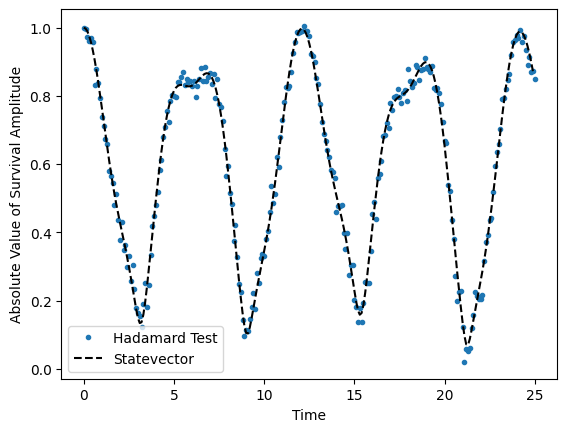

In [ ]:
plt.plot(time_range, np_abs_correlation_with_hadamard_test,
         '.', label='Hadamard Test')

sa_statevector = np.load(f'{num_q}_spin_chain_SA_obs.npy')
time = np.load(f'{num_q}_spin_chain_time.npy')
plt.plot(time, sa_statevector, '--', color='black', label='Statevector')

plt.xlabel('Time')
plt.ylabel('Absolute Value of Survival Amplitude')
plt.legend()
plt.show()

# Section 5. Variational Quantum Real-Time Evolution

In [ ]:
import numpy as np
from qiskit_algorithms import VarQRTE, TimeEvolutionProblem
from qiskit.circuit.library import ExcitationPreserving
from qiskit_algorithms.time_evolvers.variational import RealMcLachlanPrinciple
from qiskit import QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

var_principle = RealMcLachlanPrinciple()
estimator = Estimator(options={"shots": 1024})
total_time = 5.0
evolution_timestep = 0.2

hamiltonian = SparsePauliOp.from_list([("ZI", 0.5), ("IZ", 0.5), ("XX", 0.2)])

def init_circ():
    qc = QuantumCircuit(2,0)
    qc.x(0) # initial state is |10>
    return qc

# Anstaz at t=0 must be equal to the Identity
params = [np.array([0.0 for i in range(5)])]
anstaz = ExcitationPreserving(num_qubits=2, entanglement='linear', reps=1)
anstaz = init_circ().compose(anstaz)

# Define and Run the Time Evolution Problem
evolution_problem = TimeEvolutionProblem(hamiltonian, total_time)
qrte = VarQRTE(anstaz, params[0][:], variational_principle=var_principle, estimator=estimator, num_timesteps=int(total_time/evolution_timestep))
params = qrte.evolve(evolution_problem).parameter_values

# Assemble the circuit which creates the evolved state
evolved_circ = anstaz.assign_parameters(params[-1])
print(evolved_circ)

# Appendices

## A. State Initialization Algorithms

$\renewcommand{\ket}[1]{|#1\rangle}$
$\renewcommand{\bra}[1]{\langle #1|}$

### Manual state preparation using Quantum Multiplexors

The state preparation algorithm presented here is based on using the quantum multiplexor operations to transform an arbitrary state $\ket{\psi}=\left(c_1,c_2,\dots,c_{2^n}\right)^\top$ of an $n$-qubit quantum register into the vacuum state $\ket{0} = \left(1, 0, \dots, 0\right)^\top$.

\begin{equation*}
    \mathcal{R}\ket{\psi} = \ket{0}
\end{equation*}

The state preparation is then performed by applying the inverse operator $\ket{\psi} = \mathcal{R}^\dagger\ket{0}$.

The operator $\mathcal{R}$ is constructed in a recursive procedure with $n+1$ steps where the multiplexors $R^{(m)}$, $m=n,n-1,\ldots,1$ are used in first consequtive $n$ steps and the last step involves the application of a diagonal unitary operation that eliminates an accumulated global phase. The multiplexors $R^{(m)}$ are constructed as multiplexed elementary qubit rotations along the $z$ and $y$ axes represented as block-diagonal unitary operations:

\begin{align*}
    R^{(m)}
    &= \bigoplus\limits_{k_1,k_2,\dots,k_{m-1}\in\{0,1\}}
       R_y(-\theta_{k_1 k_2 \dots k_{m-1}}) R_z(-\varphi_{k_1 k_2 \dots k_{m-1}}) \nonumber\\
    &=
       \underbrace{
       \left[
       \bigoplus\limits_{k_1,k_2,\dots,k_{m-1}\in\{0,1\}}R_y(-\theta_{k_1 k_2 \dots k_{m-1}})
       \right]
       }_{R_y^{(m)}}
       \cdot
       \underbrace{
       \left[
       \bigoplus\limits_{k_1,k_2,\dots,k_{n-1}\in\{0,1\}}R_z(-\varphi_{k_1 k_2 \dots k_{m-1}})
       \right]
       }_{R_z^{(m)}}
\end{align*}

where $2^{m-1}$ angles $\varphi_{k_1 k_2 \dots k_{m-1}}$ and $\theta_{k_1 k_2 \dots k_{m-1}}$ can be obtained from the corresponding complex amplitides at each step.

The application of the multiplexed rotations is performed recursively without acting on already disentangled qubits, reducing the dimension by half in each iteration. After $n$ iterations, the resulting state will be a scalar multiple of the vacuum state $\ket{00\dots 0}$:

\begin{equation*}
    (R^{(1)}\otimes I^{\otimes(n-1)})\dots(R^{(n-2)}\otimes I\otimes I)(R^{(n-1)}\otimes I)R^{(n)}\ket{\psi} = e^{\mathrm{i}\Phi}\ket{0}\otimes\ket{0}\otimes\dots\otimes\ket{0}
\end{equation*}

or

\begin{equation*}
    \prod\limits_{m=1}^{n}\left[R^{(m)}\otimes I^{\otimes(n-m)}\right]\ket{\psi} = e^{\mathrm{i}\Phi}\ket{00\dots 0}
\end{equation*}

where $I$ is the identity operator acting on a single qubit state.

Thus the state preparation unitary operator is expressed as

\begin{equation*}
    \mathcal{R}^\dagger = \prod\limits_{m=1}^{n}\left[R^{(n-m+1)\dagger}\otimes I^{\otimes(m-1)}\right] e^{-\mathrm{i}\Phi}
\end{equation*}

In [ ]:
import numpy as np
from scipy.linalg import block_diag

def compute_bloch_angles(c0, c1):
    """
    Computes the Bloch angles from the amplitudes of a given qubit state
    c0*|0> + c1*|1>
    """
    # Normalize the amplitudes
    norm = np.sqrt(np.abs(c0)**2 + np.abs(c1)**2)
    alpha = c0/norm
    beta  = c1/norm

    # Calculate the angle theta
    theta = 2 * np.arccos(np.abs(alpha))

    # Calculate the angle phi (difference in the phases of alpha and beta)
    phi = np.angle(beta*np.conjugate(alpha)/np.abs(beta)/np.abs(alpha))

    return theta, phi

def rz_matrix(phi):
    """
    Returns the rotation matrix R_z(phi) for a rotation around the z-axis by angle phi.
    """
    return np.array([
        [np.exp(-1j*phi/2), 0],
        [0, np.exp(1j*phi/2)]
    ])

def ry_matrix(theta):
    """
    Returns the rotation matrix R_y(theta) for a rotation around the y-axis by angle theta.
    """
    return np.array([
        [np.cos(theta/2), -np.sin(theta / 2)],
        [np.sin(theta/2), np.cos(theta / 2)]
    ])

def is_power_of_two(n):
    return n > 0 and (n & (n - 1)) == 0

def multiplexor_matrix(n, vector, bit=0):
    """
    Returns the matrix for a multiplexor R^(n) with n-1 control qubits;
    _vector_ should be an numpy array with 2**n components;
    _bit_ is value (0 or 1) of the desired unentangled bit;
    """
    if bit!=0:
        bit = 1

    for i in np.arange(0,2**n,2):
        c0 = vector[i]
        c1 = vector[i+1]
        theta, phi = compute_bloch_angles(c0, c1)
        r_z = rz_matrix(-phi)
        r_y = ry_matrix(bit*np.pi-theta)
        r = r_y @ r_z
        if i==0:
            multiplexor = block_diag(r)
        else:
            multiplexor = block_diag(multiplexor,r)

    return multiplexor

def rotate_to_vacuum_matrix(vector_input):
    """
    Returns the matrix for a total multiplexed operation
    transforming a state given as vector_input into the vacuum state
    vector_input should be an numpy array with 2**n components
    """
    ndim = vector_input.size
    if not is_power_of_two(ndim):
        print("Dimension of the input state vector (",ndim,") should be a power of 2.")
        return
    else:
        n = int(np.log2(vector_input.size))

    total_matrix = np.eye(ndim)

    vector_k = vector_input.copy()
    for k in np.arange(n,0,-1):

        if k==n:
            vector_pruned = vector_input.copy()
        else:
            vector_pruned = vector_new[::2]

        multiplexor = multiplexor_matrix(k,vector_pruned)

        if k==n:
            multiplexor_padded = multiplexor
        else:
            multiplexor_padded = np.kron(multiplexor,np.eye(2*(n-k)))

        total_matrix = np.matmul(multiplexor_padded,total_matrix)
        vector_k = np.matmul(multiplexor_padded,vector_k)
        vector_new = multiplexor.dot(vector_pruned)

    phase_factor = vector_k[0]
    total_matrix = np.conjugate(phase_factor)*total_matrix

    return total_matrix

def rotate_to_state_matrix(state, vector_input):
    """
    Returns the matrix for a total multiplexed operation
    transforming "vector_input" into the "state"
    vector_input -- should be a numpy array with 2**n components
    state -- should be a binary string of length n
    """
    ndim = vector_input.size
    if not is_power_of_two(ndim):
        print("Dimension of the input state vector (",ndim,") should be a power of 2.")
        return
    else:
        n = int(np.log2(ndim))

    total_matrix = np.eye(ndim)

    vector_k = vector_input.copy()
    bit = int(state[n-1])

    for k in np.arange(n,0,-1):

        if k==n:
            vector_pruned = vector_input.copy()
        else:
            vector_pruned = vector_new[bit::2]

        bit = int(state[k-1])
        multiplexor = multiplexor_matrix(k,vector_pruned, bit)

        if k==n:
            multiplexor_padded = multiplexor
        else:
            multiplexor_padded = np.kron(multiplexor,np.eye(2*(n-k)))

        total_matrix = multiplexor_padded @ total_matrix
        vector_k = multiplexor_padded @ vector_k
        vector_new = multiplexor @ vector_pruned

    phase_factor = vector_new[bit]
    total_matrix = np.conjugate(phase_factor)*total_matrix

    return total_matrix

### Multiplexor rotations for a quantum register with 3 qubits

In [ ]:
from numpy import linalg as LA

# number of qubits and total dimension
nq = 3
ndim = 2**nq

# initialize a random state of the system
state_vector = (2*np.random.rand(8) - 1) * np.exp(1j*2*np.pi*np.random.rand(8))
state_vector /= LA.norm(state_vector)

for i in range(ndim):
    print('|',bin(i)[2:].zfill(nq),'> ',state_vector[i])

r3 = multiplexor_matrix(3, state_vector)
v3 = np.dot(r3,state_vector)
print('\nR3*v3\n',v3.reshape(-1,1))

r2 = multiplexor_matrix(2,v3[::2])
v2 = np.dot(r2,v3[::2])
print('\nR2*v2\n',v2.reshape(-1,1))

r1 = multiplexor_matrix(1,v2[::2])
v1 = np.dot(r1,v2[::2])
print('\nR1*v1\n',v1.reshape(-1,1))

print("\n Target state:\n",state_vector.reshape(-1,1))
mrot = rotate_to_vacuum_matrix(state_vector)

rot_vector = mrot.dot(state_vector)
print("\n Rotated target state (should be the vacuum state):\n",  rot_vector.reshape(-1,1))

back_vector = np.conjugate(mrot.T).dot(rot_vector)
print("\n Vacuum state rotated back (should match the target state):\n", back_vector.reshape(-1,1))

## B. Decomposition of an Arbitrary Unitary Gate

### Decomposition with Givens Rotations

In [ ]:
import numpy as np
import graycode

def GivensRotation(i, j, k, A):
    """
    Constructs a Givens rotation matrix that zeros out A[j,i] by rotating rows j and k
    Indices i, j, k are zero-based (Python convention)
    Parameters:
    i (int): Column index (0-based)
    j (int): Row index to be zeroed (element A[j,i])
    k (int): Row index to rotate with (element A[k,i])
    A (ndarray): The matrix A (NumPy array)

    Returns:
    The Givens rotation matrix (ndarray)
    """
    ndim = A.shape[0]
    iGjk = np.identity(ndim, dtype=A.dtype)
    aji = A[j, i]
    if aji == 0:
        return iGjk
    aki = A[k, i]
    norm = np.sqrt(abs(aji)**2 + abs(aki)**2)
    iGjk[k, k] = np.conj(aki) / norm
    iGjk[j, j] = aki / norm
    iGjk[k, j] = np.conj(aji) / norm
    iGjk[j, k] = -aji / norm
    return iGjk

def Gmatrix(U, gray=False, print_sequence=False):
    """
    Computes a transformation matrix R based on Givens rotations applied to U.
    Parameters:
    U (ndarray): A square NumPy array representing the matrix U.
    Returns:
    ndarray: The transformation matrix R@Uphase.
    """
    ndim = U.shape[0]
    n = int(np.log2(ndim))
    R = np.identity(ndim, dtype=U.dtype)

    # Compute the phase adjustment to make the determinant of Uphase @ U real
    detU = np.linalg.det(U)
    argDetU = np.angle(detU)
    phase_factor = np.exp(-1j * argDetU / ndim)
    Uphase = phase_factor * np.identity(ndim, dtype=U.dtype)

    # Adjust U with the phase factor
    Um = Uphase @ U

    # Perform Givens rotations to zero out below-diagonal elements
    if print_sequence:
        print("U = D", end=' ')
    for i in range(ndim - 1):  # i from 0 to ndim-2
        for j in range(ndim - 1, i, -1):  # j from ndim-1 down to i+1
            if gray:
                ii = graycode.gen_gray_codes(n)[i]
                jj = graycode.gen_gray_codes(n)[j]
                kk = graycode.gen_gray_codes(n)[j-1]
            else:
                ii = i
                jj = j
                kk = j-1
            if print_sequence:
                print(f"G^+[{ii+1},{jj+1},{kk+1}]", end=' ')
            RG = GivensRotation(ii, jj, kk, Um)
            R = RG @ R
            Um = RG @ Um

    if print_sequence:
        print()
        print(f"D = {np.conjugate(phase_factor)}*I")

    return R @ Uphase

### Decomposition of a Random $[4\times 4]$ Unitary

In [ ]:
from scipy.stats import unitary_group

def print_nicely(matrix):
    for row in matrix:
        for element in row:
            print(f"{element:15.4f}", end=" ")
        print()

# Example: [4x4] random unitary matrix U
ndim = 4
U = unitary_group.rvs(ndim)
print("\nTarget unitary matrix U:")
print(  "------------------------")
print_nicely(U)

# Compute the transformation matrix using the Gray code ordering
print("\nDecomposition:")
print(  "--------------")
RU = Gmatrix(U,gray=True, print_sequence=True)
U_transformed = RU @ U

# Verify the result (depends on your specific use case)
print("\nTransformed Matrix R @ U (should be identity matrix):")
print(  "-----------------------------------------------------")
print_nicely(U_transformed)